Pildituvastuse ülesanne
----

Lahenduses kasutati `face_recognition` Pythoni library.

Riistvara:
- CPU: Intel i7-9700
- RAM: 16GB

Mudeli treenimisel kasutati 69 erineva poliitikut, kust iga ühe kohta oli 10 pilti. Kokku on treeningandmeid 690 pilti ning testandmeid 10 pilti. 

Ülesande eesmärk on proovida ära tuvastada õigesti kõik testandmed.

In [16]:
"""
Source: https://github.com/ageitgey/face_recognition/blob/master/examples/face_recognition_knn.py

This is an example of using the k-nearest-neighbors (KNN) algorithm for face recognition.
When should I use this example?
This example is useful when you wish to recognize a large set of known people,
and make a prediction for an unknown person in a feasible computation time.
Algorithm Description:
The knn classifier is first trained on a set of labeled (known) faces and can then predict the person
in an unknown image by finding the k most similar faces (images with closet face-features under euclidean distance)
in its training set, and performing a majority vote (possibly weighted) on their label.
For example, if k=3, and the three closest face images to the given image in the training set are one image of Biden
and two images of Obama, The result would be 'Obama'.
* This implementation uses a weighted vote, such that the votes of closer-neighbors are weighted more heavily.
Usage:
1. Prepare a set of images of the known people you want to recognize. Organize the images in a single directory
   with a sub-directory for each known person.
2. Then, call the 'train' function with the appropriate parameters. Make sure to pass in the 'model_save_path' if you
   want to save the model to disk so you can re-use the model without having to re-train it.
3. Call 'predict' and pass in your trained model to recognize the people in an unknown image.
NOTE: This example requires scikit-learn to be installed! You can install it with pip:
$ pip3 install scikit-learn
"""

import math
from sklearn import neighbors
import os
import os.path
import pickle
from PIL import Image, ImageDraw
import face_recognition
from face_recognition.face_recognition_cli import image_files_in_folder
from IPython.display import display


ALLOWED_EXTENSIONS = {'png', 'jpg', 'jpeg'}


def train(train_dir, model_save_path=None, n_neighbors=None, knn_algo='ball_tree', verbose=False):
    """
    Trains a k-nearest neighbors classifier for face recognition.
    :param train_dir: directory that contains a sub-directory for each known person, with its name.
     (View in source code to see train_dir example tree structure)
     Structure:
        <train_dir>/
        ├── <person1>/
        │   ├── <somename1>.jpeg
        │   ├── <somename2>.jpeg
        │   ├── ...
        ├── <person2>/
        │   ├── <somename1>.jpeg
        │   └── <somename2>.jpeg
        └── ...
    :param model_save_path: (optional) path to save model on disk
    :param n_neighbors: (optional) number of neighbors to weigh in classification. Chosen automatically if not specified
    :param knn_algo: (optional) underlying data structure to support knn.default is ball_tree
    :param verbose: verbosity of training
    :return: returns knn classifier that was trained on the given data.
    """
    X = []
    y = []

    # Loop through each person in the training set
    for class_dir in os.listdir(train_dir):
        if not os.path.isdir(os.path.join(train_dir, class_dir)):
            continue

        # Loop through each training image for the current person
        for img_path in image_files_in_folder(os.path.join(train_dir, class_dir)):
            image = face_recognition.load_image_file(img_path)
            face_bounding_boxes = face_recognition.face_locations(image)

            if len(face_bounding_boxes) != 1:
                # If there are no people (or too many people) in a training image, skip the image.
                if verbose:
                    print("Image {} not suitable for training: {}".format(img_path, "Didn't find a face" if len(face_bounding_boxes) < 1 else "Found more than one face"))
            else:
                # Add face encoding for current image to the training set
                X.append(face_recognition.face_encodings(image, known_face_locations=face_bounding_boxes)[0])
                y.append(class_dir)

    # Determine how many neighbors to use for weighting in the KNN classifier
    if n_neighbors is None:
        n_neighbors = int(round(math.sqrt(len(X))))
        if verbose:
            print("Chose n_neighbors automatically:", n_neighbors)

    # Create and train the KNN classifier
    knn_clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=knn_algo, weights='distance')
    knn_clf.fit(X, y)

    # Save the trained KNN classifier
    if model_save_path is not None:
        with open(model_save_path, 'wb') as f:
            pickle.dump(knn_clf, f)

    return knn_clf


def predict(X_img_path, knn_clf=None, model_path=None, distance_threshold=0.6):
    """
    Recognizes faces in given image using a trained KNN classifier
    :param X_img_path: path to image to be recognized
    :param knn_clf: (optional) a knn classifier object. if not specified, model_save_path must be specified.
    :param model_path: (optional) path to a pickled knn classifier. if not specified, model_save_path must be knn_clf.
    :param distance_threshold: (optional) distance threshold for face classification. the larger it is, the more chance
           of mis-classifying an unknown person as a known one.
    :return: a list of names and face locations for the recognized faces in the image: [(name, bounding box), ...].
        For faces of unrecognized persons, the name 'unknown' will be returned.
    """
    if not os.path.isfile(X_img_path) or os.path.splitext(X_img_path)[1][1:] not in ALLOWED_EXTENSIONS:
        raise Exception("Invalid image path: {}".format(X_img_path))

    if knn_clf is None and model_path is None:
        raise Exception("Must supply knn classifier either thourgh knn_clf or model_path")

    # Load a trained KNN model (if one was passed in)
    if knn_clf is None:
        with open(model_path, 'rb') as f:
            knn_clf = pickle.load(f)

    # Load image file and find face locations
    X_img = face_recognition.load_image_file(X_img_path)
    X_face_locations = face_recognition.face_locations(X_img)

    # If no faces are found in the image, return an empty result.
    if len(X_face_locations) == 0:
        return []

    # Find encodings for faces in the test iamge
    faces_encodings = face_recognition.face_encodings(X_img, known_face_locations=X_face_locations)

    # Use the KNN model to find the best matches for the test face
    closest_distances = knn_clf.kneighbors(faces_encodings, n_neighbors=1)
    are_matches = [closest_distances[0][i][0] <= distance_threshold for i in range(len(X_face_locations))]
    
    # Predict classes and remove classifications that aren't within the threshold
    return [(pred, loc, preds) if rec else ("unknown", loc, [0]) 
            for pred, loc, rec, preds
            in zip(
                knn_clf.predict(faces_encodings),
                X_face_locations,
                are_matches,
                knn_clf.predict_proba(faces_encodings))]


def show_prediction_labels_on_image(img_path, predictions):
    """
    Shows the face recognition results visually.
    :param img_path: path to image to be recognized
    :param predictions: results of the predict function
    :return:
    """
    pil_image = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(pil_image)

    for name, (top, right, bottom, left), preds in predictions:
        # Draw a box around the face using the Pillow module
        draw.rectangle(((left, top), (right, bottom)), outline=(0, 0, 255))

        # There's a bug in Pillow where it blows up with non-UTF-8 text
        # when using the default bitmap font
        confidence = round(max(preds) / max(sum(preds), 0.01) * 100, 2)
        text = (name + " with confidence: " + str(confidence) + "%").encode("UTF-8")

        # Draw a label with a name below the face
        text_width, text_height = draw.textsize(text)
        draw.rectangle(((left, bottom - text_height - 10), (right, bottom)), fill=(0, 0, 255), outline=(0, 0, 255))
        draw.text((left + 6, bottom - text_height - 5), text, fill=(255, 255, 255, 255))

    # Remove the drawing library from memory as per the Pillow docs
    del draw

    # Display the resulting image
    %matplotlib inline
    display(pil_image)

In [2]:
# STEP 1: Train the KNN classifier and save it to disk
# Once the model is trained and saved, you can skip this step next time.
print("Training KNN classifier...")
classifier = train("train", model_save_path="trained_knn_model.clf", n_neighbors=2)
print("Training complete!")

Training KNN classifier...


C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Training complete!


Looking for faces in artur_talvik.png
- Found Artur Talvik at (205, 170)


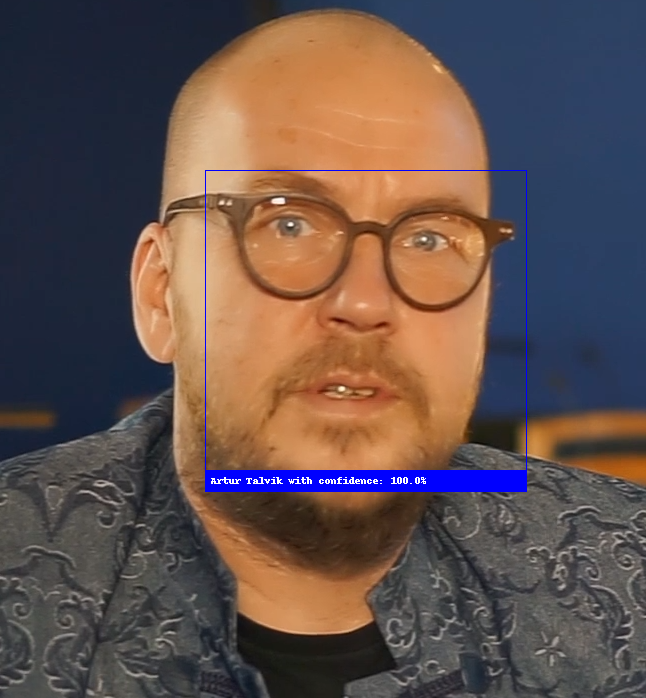

Looking for faces in barbi_pilvre.png
- Found Barbi Pilvre at (339, 211)


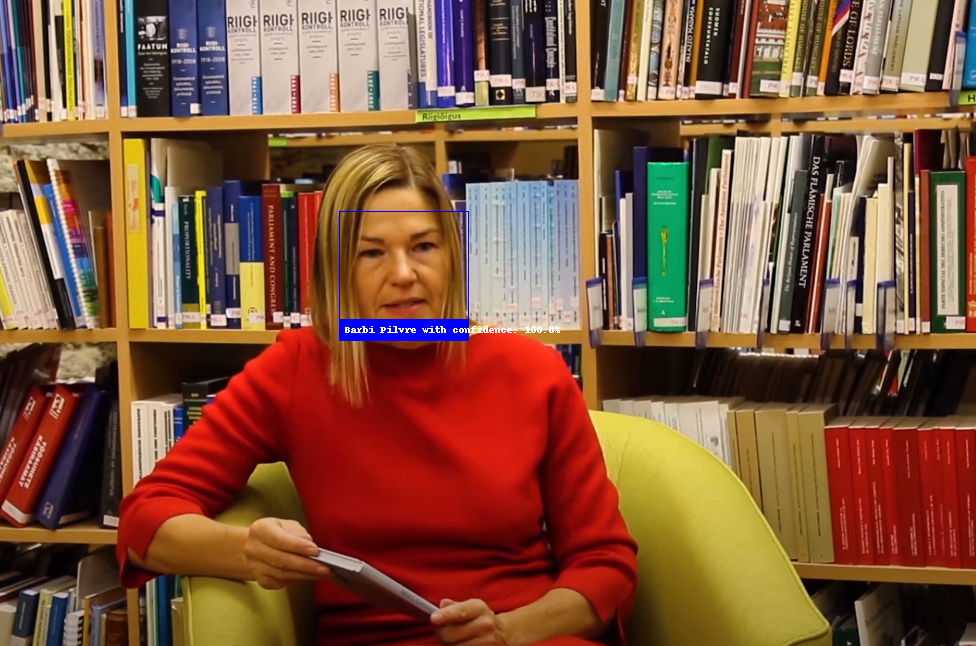

Looking for faces in jaanus_karilaid.png
- Found Jaanus Karilaid at (170, 206)


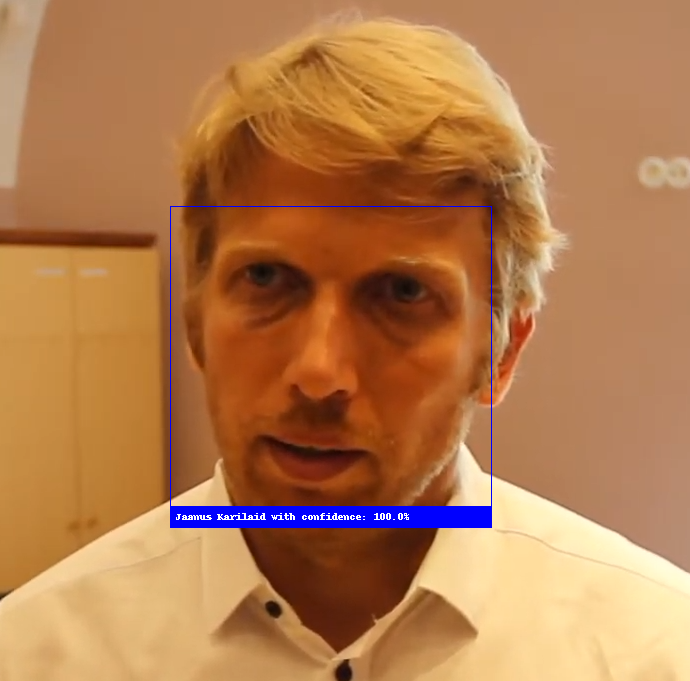

Looking for faces in jevgeni_ossinovski.png
- Found Jevgeni Ossinovski at (491, 170)


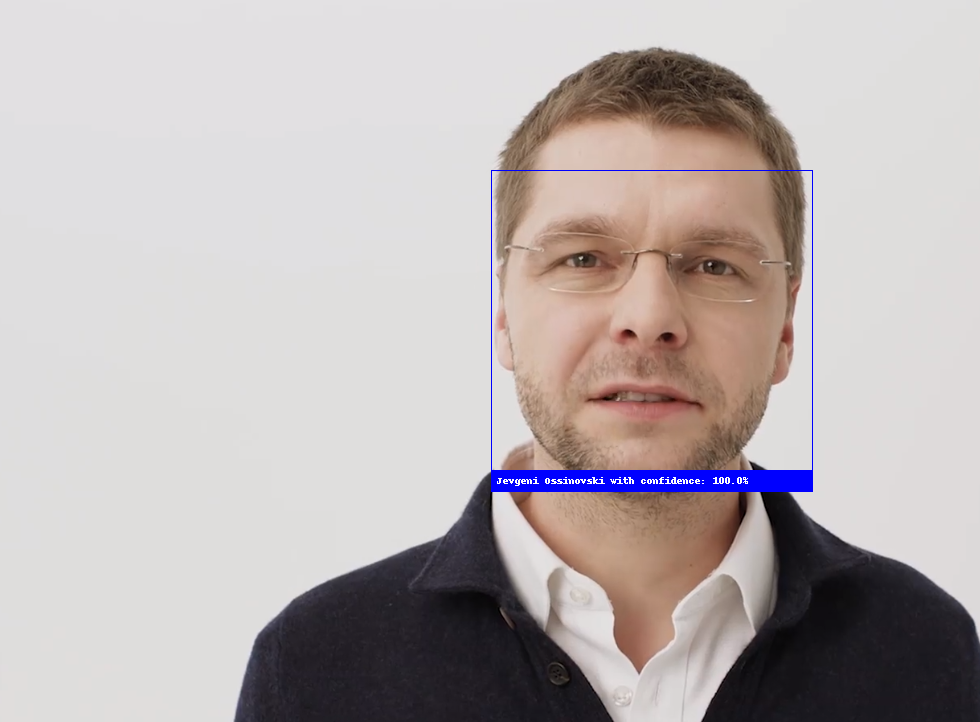

Looking for faces in jüri_ratas.png
- Found Jüri Ratas at (438, 142)


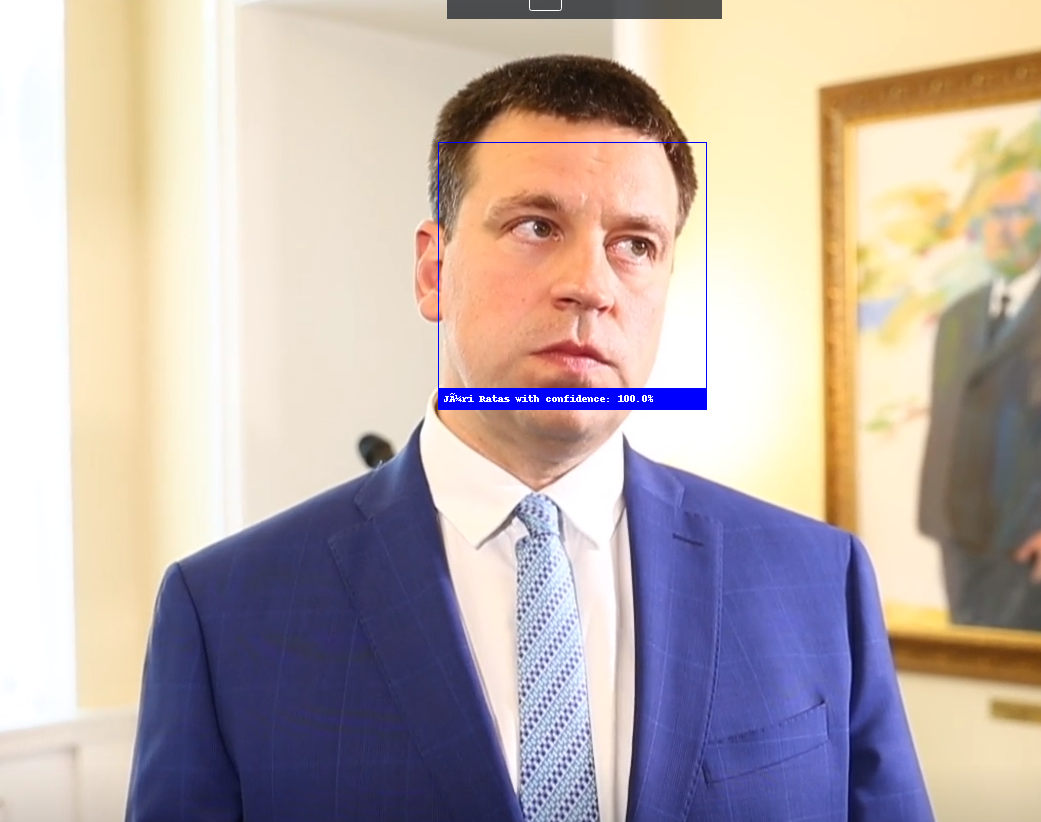

Looking for faces in kalle_palling.png
- Found Kalle Palling at (141, 142)


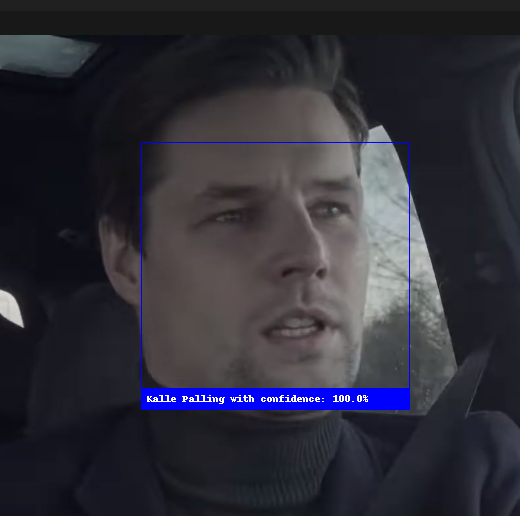

Looking for faces in krista_aru.png
- Found Krista Aru at (294, 247)


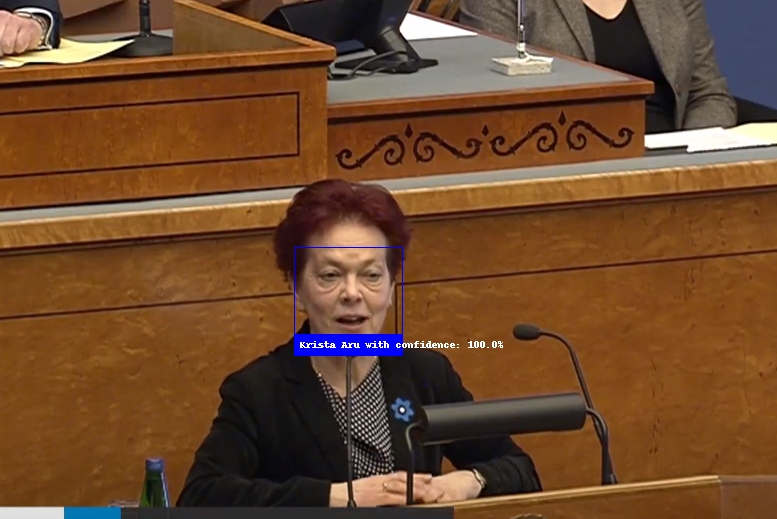

Looking for faces in lauri_luik.png
- Found Lauri Luik at (141, 201)


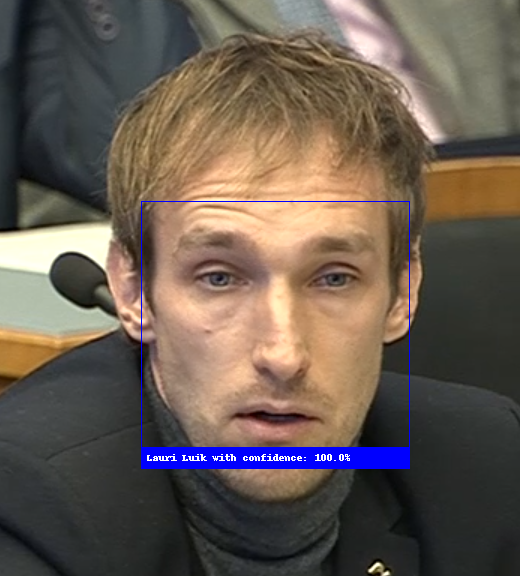

Looking for faces in siret_kotka.png
- Found Siret Kotka at (134, 170)


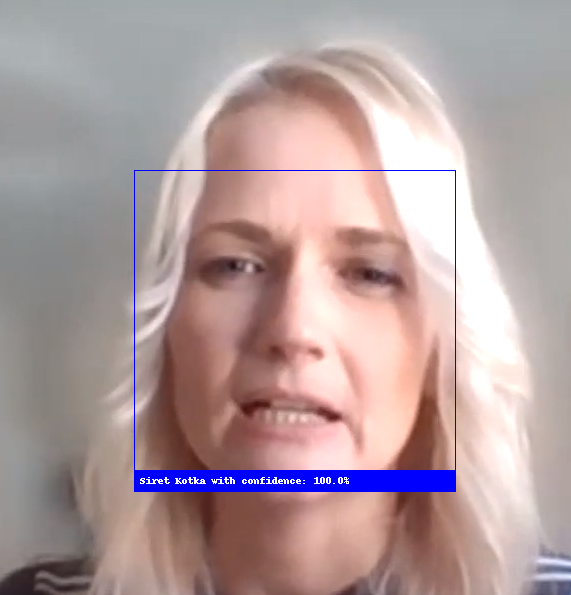

Looking for faces in yoko_alender.png
- Found Yoko Alender at (290, 76)


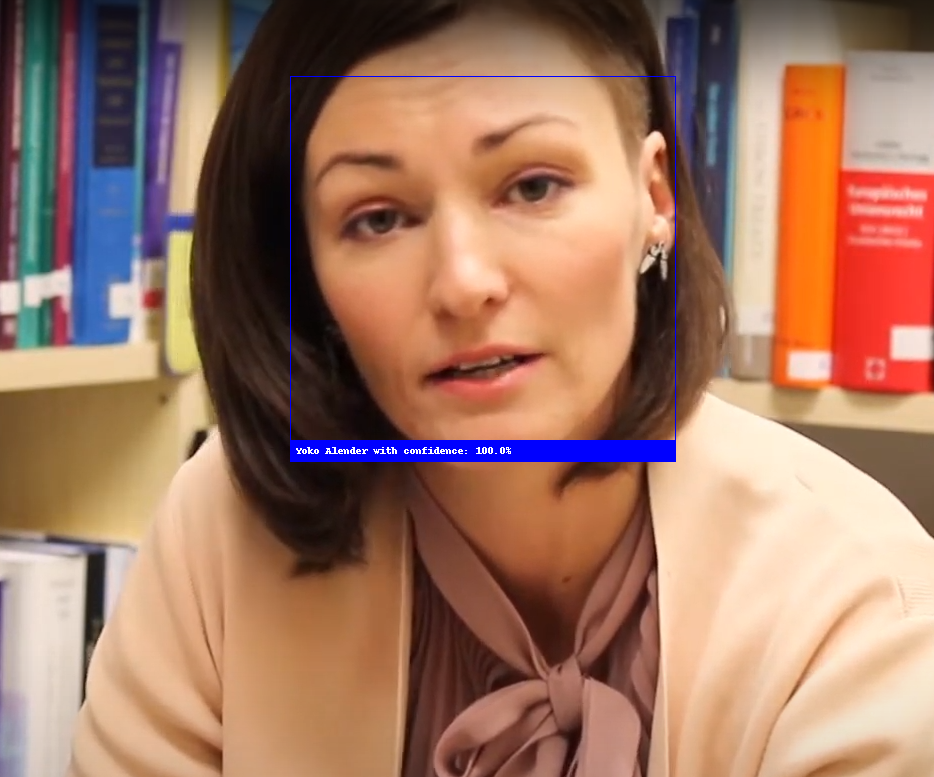

In [9]:
# STEP 2: Using the trained classifier, make predictions for unknown images
for image_file in os.listdir("test"):
    full_file_path = os.path.join("test", image_file)

    print("Looking for faces in {}".format(image_file))

    # Find all people in the image using a trained classifier model
    # Note: You can pass in either a classifier file name or a classifier model instance
    predictions = predict(full_file_path, model_path="trained_knn_model.clf")

    # Print results on the console
    for name, (top, right, bottom, left), score in predictions:
        print("- Found {} at ({}, {})".format(name, left, top))

    # Display results overlaid on an image
    show_prediction_labels_on_image(os.path.join("test", image_file), predictions)

Vahehinnang
----

Kümme pilti kümnest suudeti õigesti ära tuvastada.

Eksperimenteerib lisaks, et kas mudel suudam inimese nägu ära tuvastada siis, kui
- see on küljega
- seda pole andmestikus
- on kümme aastat vana pilt halva resolutsiooniga

Looking for faces in anne_sulling.png
- Found unknown at (221, 118)


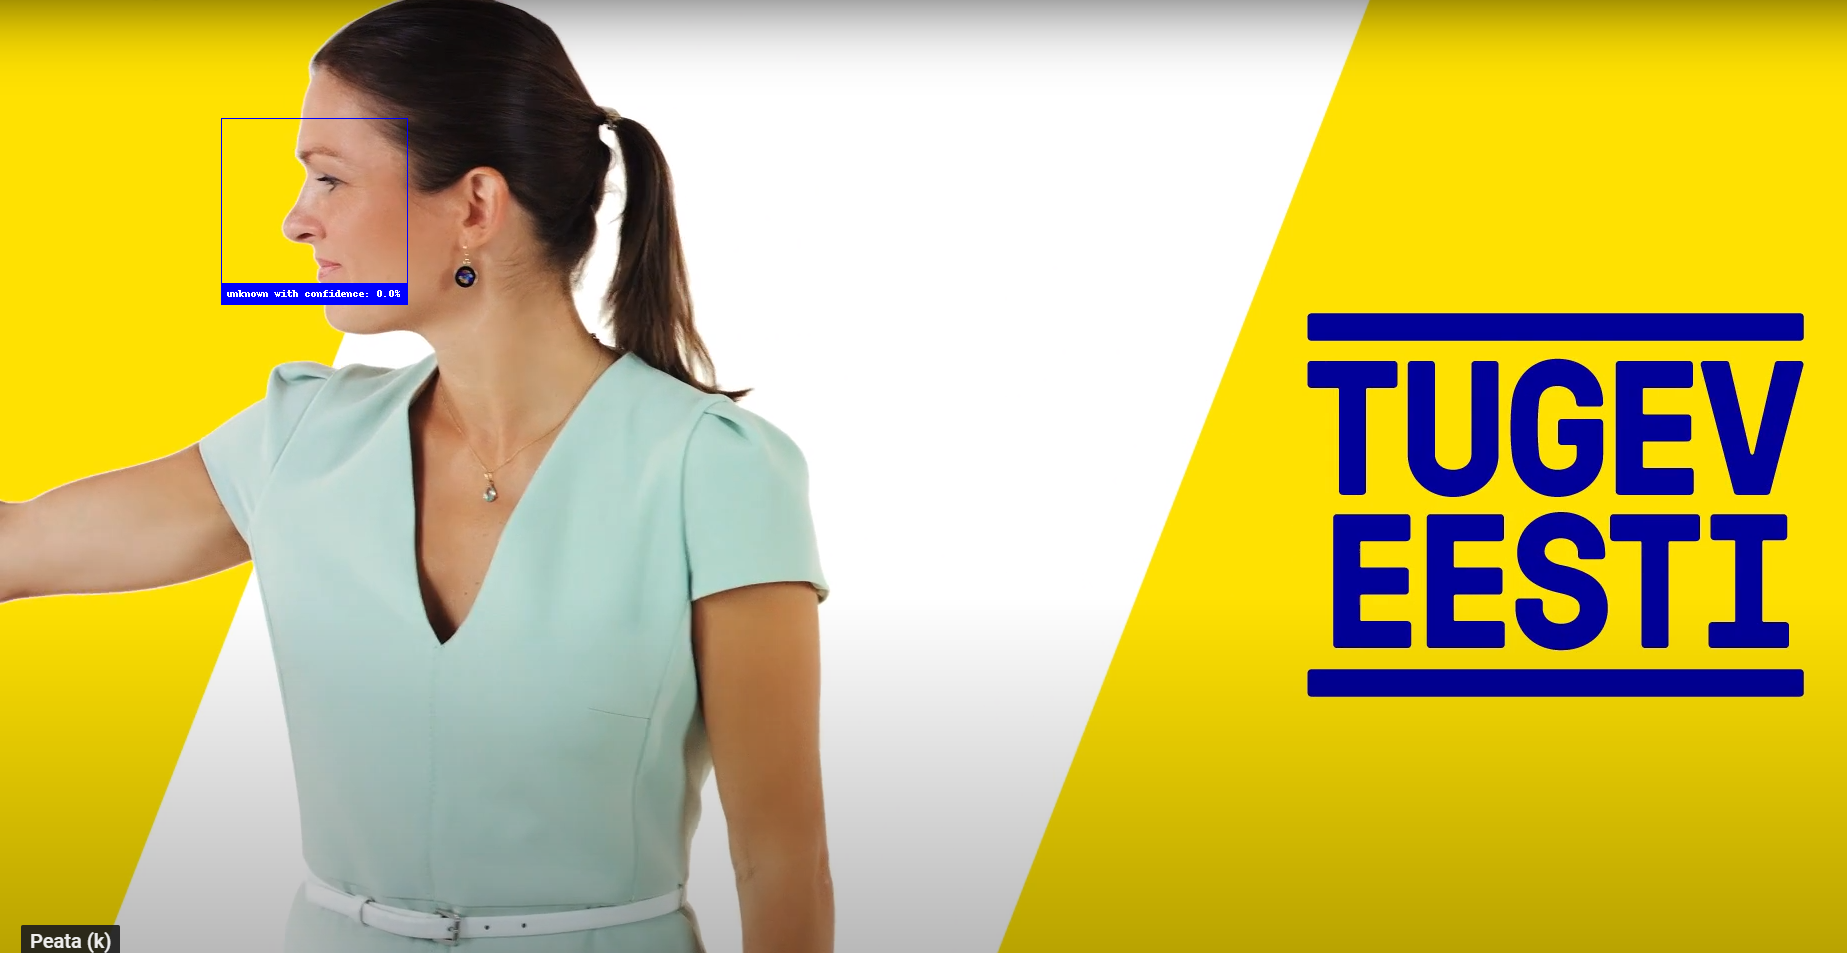

Looking for faces in donald_trump.png
- Found Johannes Kert at (218, 98)


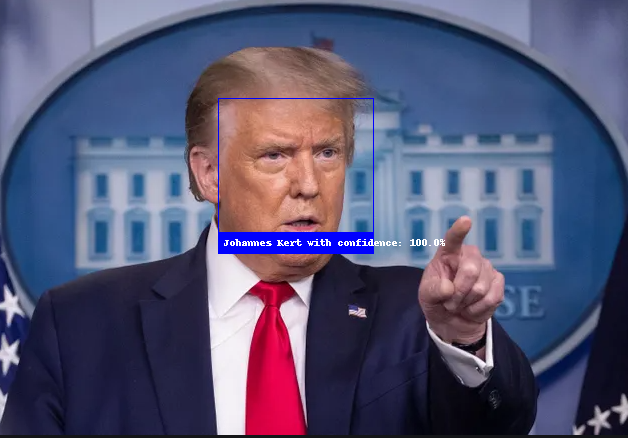

Looking for faces in margus_tsahkna.png
- Found Margus Tsahkna at (191, 167)


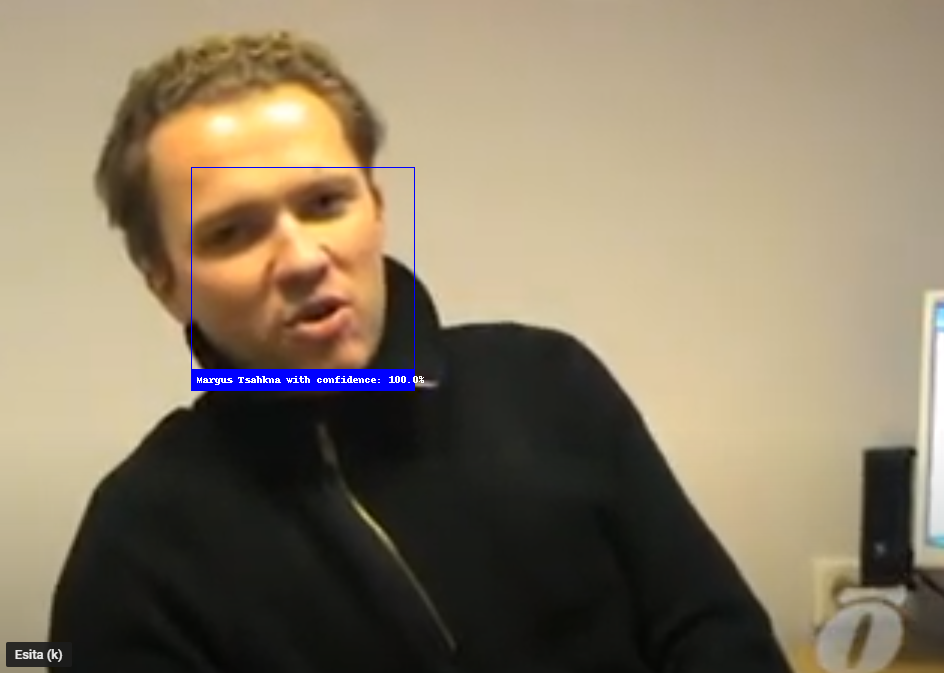

In [17]:
# STEP 3: Try some random faces and other hard cases to truly push it to the limit
for image_file in os.listdir("hard_test"):
    full_file_path = os.path.join("hard_test", image_file)

    print("Looking for faces in {}".format(image_file))

    # Find all people in the image using a trained classifier model
    # Note: You can pass in either a classifier file name or a classifier model instance
    predictions = predict(full_file_path, model_path="trained_knn_model.clf")

    # Print results on the console
    for name, (top, right, bottom, left), score in predictions:
        print("- Found {} at ({}, {})".format(name, left, top))

    # Display results overlaid on an image
    show_prediction_labels_on_image(os.path.join("hard_test", image_file), predictions)

Hinnang
----

Lisa eksperimenteerimine
- küljega pilte ei suudetud ära tuvastada, mis on ka oodatav
- andmestikus puuduvaid pilte ei suudeta samuti ära tuvastada
- vanu pilte aga halva resolutsiooniga suudeti hästi ära tuvastada

Kokkuvõtteks ütleks, et antud näotuvastuse library suudab väga edukalt ja kiiresti tuvastada nägusid. Mõistuse piirides olevatest testidest suudeti kõik kümme nägu õigesti tuvastada. Otseselt kood muutmist ei vajanud. 

Kood töötas järgmiselt, et tuvastati ära näojooned ning iga treeningandme pildiga lisati n dimensionaalsesse ruumi üks punkt, kus dimensioonid on erinevad näo atribuudid ning õige vastus on test andme punktile kõige lähem treeningandme punkt. Näotuvastusest räägib lähemalt järgmine artikkel: https://medium.com/@ageitgey/machine-learning-is-fun-part-4-modern-face-recognition-with-deep-learning-c3cffc121d78